online keras course : https://www.tensorflow.org/tutorials/images/classification

In [1]:
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    data_dir = '/kaggle/input/food41/images/'
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'
    !pip install --quiet -r requirements.txt
    !python download_data.py

Kaggle environment detected


In [3]:
# Uncomment to select few classes

#classes_to_keep = ['beef_tartare', 'hamburger', 'panna_cotta', 'pizza']
#
#if running_on_kaggle:
#    for elt in classes_to_keep:
#        try:
#            shutil.copytree(data_dir + elt,'/kaggle/temp/images_kept/' + elt)
#        except:
#            print("class ", elt, "already copied !")
#    data_dir = '/kaggle/temp/images_kept/'
#else:
#    for elt in classes_to_keep:
#        shutil.copytree(data_dir + elt,'./dataset/food/images_kept/' + elt, dirs_exist_ok=True)
#    data_dir = './dataset/food/images_kept/'

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width))

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


2022-03-04 08:45:53.777092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 08:45:53.883537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 08:45:53.884274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 08:45:53.886779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

2022-03-04 08:45:58.537307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


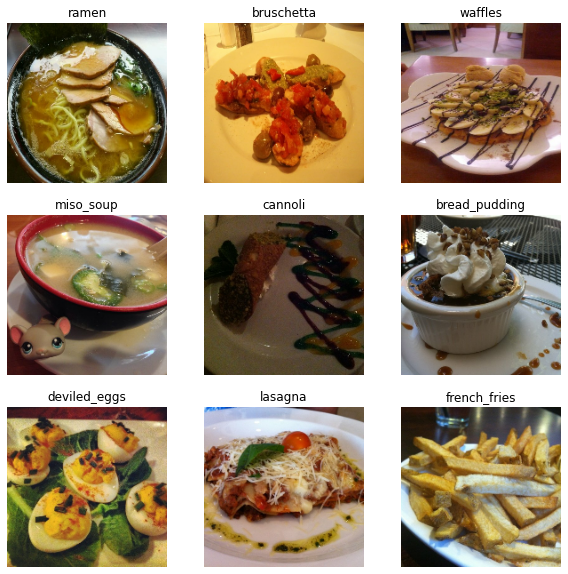

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
# Put the images in RAM, quicker but only works with few images

#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

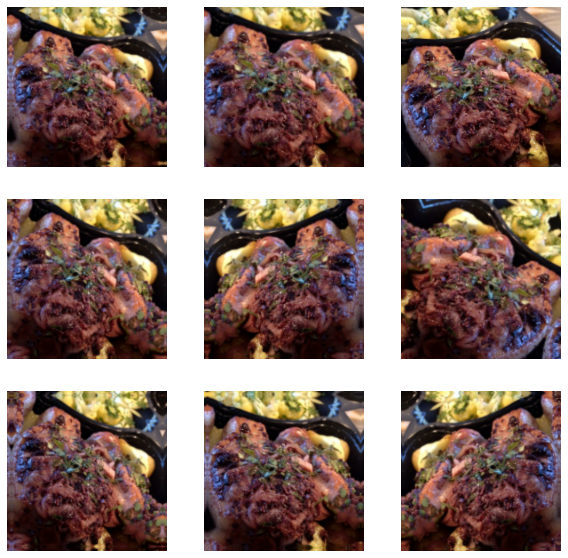

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(100):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Training

In [11]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2022-03-04 08:46:31.377043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2525/2525 [==============================] - 498s 194ms/step - loss: 4.2189 - accuracy: 0.0671 - val_loss: 3.8965 - val_accuracy: 0.1119
Epoch 2/10
2525/2525 [==============================] - 179s 71ms/step - loss: 3.7470 - accuracy: 0.1389 - val_loss: 3.6238 - val_accuracy: 0.1565
Epoch 3/10
2525/2525 [==============================] - 176s 70ms/step - loss: 3.4928 - accuracy: 0.1813 - val_loss: 3.4914 - val_accuracy: 0.1797
Epoch 4/10
2525/2525 [==============================] - 182s 72ms/step - loss: 3.3467 - accuracy: 0.2055 - val_loss: 3.3857 - val_accuracy: 0.2002
Epoch 5/10
2525/2525 [==============================] - 180s 71ms/step - loss: 3.2443 - accuracy: 0.2272 - val_loss: 3.3322 - val_accuracy: 0.2135
Epoch 6/10
2525/2525 [==============================] - 179s 71ms/step - loss: 3.1798 - accuracy: 0.2399 - val_loss: 3.2156 - val_accuracy: 0.2347
Epoch 7/10
2525/2525 [==============================] - 177s 70ms/step - loss: 3.1256 - accuracy: 0.2515 - val_loss: 3.2598 - va

In [18]:
if running_on_kaggle:
    model.save('/kaggle/working/saved_model/')
else:
    model.save('./saved_model/')

2022-03-04 09:24:14.634123: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


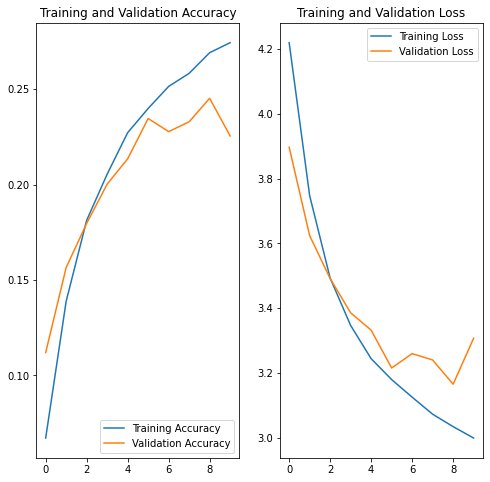

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Unseen data prediction

In [17]:
pizza_url = "https://img.cuisineaz.com/660x660/2021/02/25/i159373-pizza-margherita.jpeg"
pizza_path = tf.keras.utils.get_file('pizza', origin=pizza_url)

img = tf.keras.utils.load_img(
    pizza_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

212992/202559 [===============================] - 0s 2us/step
This image most likely belongs to pizza with a 16.08 percent confidence.
